In [1]:
import librosa
import changefinder
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

In [2]:
SR = 44100
HOP_LENGTH = 44100//4

In [6]:
y, sr = librosa.load("../dataset/sample.wav", sr=SR)

In [7]:
blocks = []
for i in range(0, len(y) - SR, HOP_LENGTH):
    blocks.append(y[i:i+SR])

# スペクトルとクロマグラムの時間類似度を計算する

In [8]:
specs = []
chromes = []

spec_sim = []
chromes_sim = []

BUF_NUM = 12

for b in blocks:
    y_harmonic, y_percussive = librosa.effects.hpss(b)

    C = np.average(librosa.feature.chroma_cens(y=y_harmonic, sr=sr), axis=1)
    D = np.average(librosa.amplitude_to_db(np.abs(librosa.stft(b)), ref=np.max), axis=1)[:512]

    C /= np.linalg.norm(C, ord=2)
    D /= np.linalg.norm(D, ord=2)

    specs.append(D)
    chromes.append(C)

    if len(specs) > BUF_NUM:
        s1 = np.average(np.dot(specs[-1], np.array(specs[-(BUF_NUM-1):-1]).T))
        specs.pop()
        spec_sim.append(s1)
    if len(chromes) > BUF_NUM*12:
        s2 = np.average(np.dot(chromes[-1], np.array(chromes[-(BUF_NUM-1):-1]).T))
        chromes.pop()
        chromes_sim.append(s2)

# change_finderを使って類似度の変化点を検知する

In [9]:
cf_spec = changefinder.ChangeFinder(r=0.1, order=1, smooth=4)
cf_chrome = changefinder.ChangeFinder(r=0.1, order=1, smooth=4)

In [10]:
score_s, score_c = [], []
for s, c in zip(spec_sim, chromes_sim):
    score_s.append(cf_spec.update(s))
    score_c.append(cf_chrome.update(c))

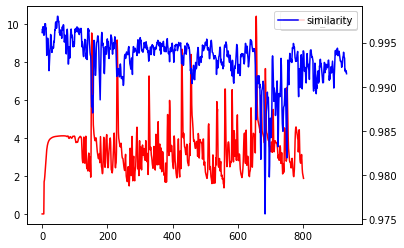

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(score_s, label="cf_score", c='red')
plt.legend()
ax2 = ax.twinx()
ax2.plot(spec_sim, label="similarity", c='blue')
plt.legend()

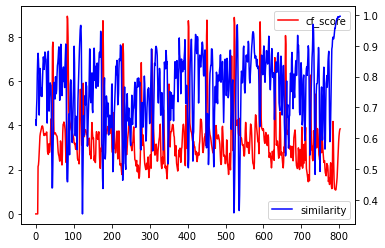

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(score_c, label="cf_score", c='red')
plt.legend()
ax2 = ax.twinx()
ax2.plot(chromes_sim, label="similarity", c='blue')
plt.legend()